<a href="https://colab.research.google.com/github/tatha04/Machine-Learning-Phase-Transitions/blob/main/Machine_Learning_Phase_Transitions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will use artificial neural networks and supervised machine learning to classify phases of the nearest-neighbor Ising model with ferromagnetic interactions. The training and test datasets have been generated separately. 

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from keras.utils import to_categorical

### Read the data file for training the model.

In [2]:
ising_data = pd.read_csv('/content/drive/MyDrive/Data Science/Data_Sets/Ising/Ising_data1.csv')

In [3]:
ising_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,Temp
0,0,-1,-1,1,1,1,1,-1,1,1,1,1,1,1,-1,1,-1,-1,-1,1,-1,1,1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,1,1,1,-1,-1,1,-1,...,1,-1,1,-1,-1,-1,1,-1,1,1,1,1,1,1,-1,1,-1,1,1,1,-1,1,1,1,-1,-1,1,1,-1,1,-1,-1,1,-1,1,1,-1,1,-1,4.9
1,1,1,-1,-1,1,1,-1,-1,-1,1,1,1,1,1,-1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,-1,1,-1,...,1,-1,1,-1,-1,-1,1,-1,-1,1,-1,1,1,1,-1,1,-1,1,1,1,-1,1,1,1,-1,-1,1,1,-1,1,-1,1,1,-1,-1,1,-1,1,-1,4.9
2,2,1,-1,1,1,1,-1,-1,-1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,1,1,1,-1,-1,1,1,1,-1,1,1,1,-1,-1,1,1,-1,1,-1,1,1,-1,-1,1,-1,1,-1,4.9
3,3,1,-1,1,1,1,-1,1,-1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,1,1,4.9
4,4,1,1,1,1,1,-1,1,-1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,-1,-1,-1,1,-1,1,1,4.9


The data file contains lattice configurations obtained using Monte-Carlo simulations of the nearest-neighbour ferromagnetic Ising model. For each initial high-temperature configuration, the temperature is gradually reduced from $T/J = 4.9$ to $T/J = 0.5$ in steps of $\delta T/J = 0.1$. (Number of temperature values *ntemp* = 45). At each temperature value, *n_meas* = 10 lattice configurations are saved. Finally, this process is repeated for *n_init_config* = 10 initial configurations. Thus the data file contains a total of 10 x 10 x 45 = 4500 lattice configurations (100 configurations at each temperature value). The square lattice consisting of 20 x 20 sites are reshaped into an array of size = 400  containing values of $\pm1$, depending on whether the site contains a spin $\uparrow$ or $\downarrow$.

In [4]:
X = ising_data.drop(['Temp','Unnamed: 0'],axis=1)
X.shape

(4500, 400)

Obtain the magnetization and magnetic susceptibility for each lattice configuration.

In [5]:
L = 20
m = X.sum(axis=1)/L**2; m2 = ((X*X).sum(axis=1))/L**2; 
temp = ising_data['Temp']; chi = (m2 - m**2)/temp

mag = pd.DataFrame({'m': m,
                     'chi' : chi,
                     'Temp' : temp})

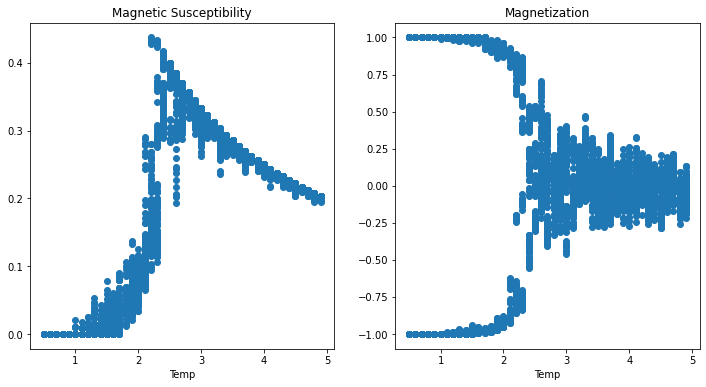

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Magnetic Susceptibility')
plt.xlabel('Temp')
plt.scatter(temp,chi)
plt.subplot(122)
plt.title('Magnetization')
plt.xlabel('Temp')
plt.scatter(temp,m)

### Critical Temperature ($T=T_c$)

For each Monte-Carlo simulation, plot the magnetic susceptibility ($\chi$) 
as a function of temperature. The critical temperature $T_c$ for this particular run can be approximated as the temperature at which the $\chi$ is maximum. $T_c$ is obtained by taking an average over all these values.

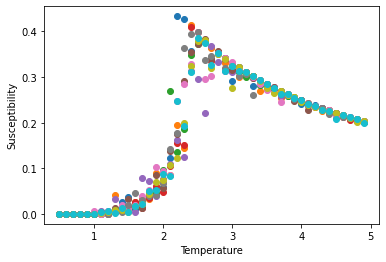


 Critical temperatures:
[2.2 2.4 2.6 2.4 2.7 2.6 2.5 2.5 2.6 2.5]

 Average critical temperature <Tc> =  2.5000000000000004


In [7]:
n_init_config = 10; n_meas = 10;
thi = 4.9; tlo = 0.5; tstep = 0.1; ntemp = int((thi-tlo)/tstep)+1;
temperatures = np.linspace(thi,tlo,ntemp);
chi_config = np.zeros((ntemp,n_init_config))
m_config   = np.zeros((ntemp,n_init_config))
for j in range(n_init_config):
  for i in range(ntemp):
    chi_config[i,j] = np.average(mag['chi'][j*n_meas*ntemp+i*n_meas:j*n_meas*ntemp+(i+1)*n_meas-1])
    m_config[i,j]   = np.average(mag['m'][j*n_meas*ntemp+i*n_meas:j*n_meas*ntemp+(i+1)*n_meas-1])

plt.figure()
plt.ylabel('Susceptibility')
plt.xlabel('Temperature')

for i in range(n_init_config):
  plt.scatter(temperatures,chi_config[:,i])

plt.show()

Tcs = temperatures[np.argmax(chi_config,axis=0)]
Tc = np.average(Tcs)

print('\n Critical temperatures:')
print(Tcs)
print('\n Average critical temperature <Tc> = ',Tc)

## Plot the average magnetization and susceptibility.

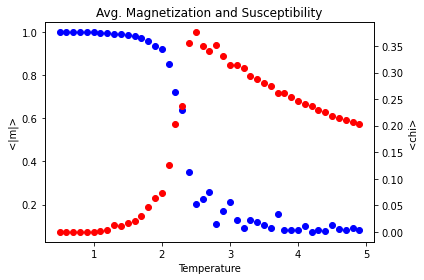

In [8]:
mag.sort_values(by='Temp', ascending=False, inplace = True)
# mag['Temp'].value_counts()

nvalues = n_init_config*n_meas
chi_avg = np.zeros((ntemp))
m_avg = np.zeros((ntemp))
for i in range(ntemp):
  chi_avg[i] = np.average(mag['chi'][i*nvalues:(i+1)*nvalues-1])
  m_avg[i]   = np.average(abs(mag['m'][i*nvalues:(i+1)*nvalues-1]))

fig, ax1 = plt.subplots()

plt.title('Avg. Magnetization and Susceptibility')
plt.scatter(temperatures,m_avg,color='b')
plt.ylabel('<|m|>')
plt.xlabel('Temperature')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.ylabel('<chi>')
plt.scatter(temperatures,chi_avg,color='r')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Lattice Configurations

Let us plot sample lattice configurations from the three cases:
*   High-temperature ($T \gt T_c$): There is no long-range order. The spins $\uparrow$ and $\downarrow$ are randomly distributed.
*   Critical temperature ($T \approx T_c \approx 2.5 $): The spins begin to demonsrate long-range order. Hence, domains of either spin $\uparrow$ or $\downarrow$ appears.
*   Low-temperature ($T \lt T_c$): All the spins are aligned either $\uparrow$ or $\downarrow$ exhibitng long range order.

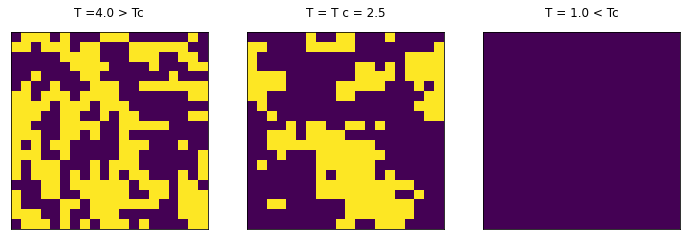

In [9]:
# Plot T<Tc, T>Tc, and T=Tc

lattice_T_gt_Tc = ising_data.loc[ising_data['Temp']==4.0].sample().drop(['Temp','Unnamed: 0'],axis=1).values.reshape((20,20))
lattice_T_eq_Tc = ising_data.loc[ising_data['Temp']==2.5].sample().drop(['Temp','Unnamed: 0'],axis=1).values.reshape((20,20))
lattice_T_lt_Tc = ising_data.loc[ising_data['Temp']==1.0].sample().drop(['Temp','Unnamed: 0'],axis=1).values.reshape((20,20))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

axes[0].matshow(lattice_T_gt_Tc)
axes[0].set_title("T =4.0 > Tc")
axes[1].matshow(lattice_T_eq_Tc)
axes[1].set_title("T = T c = 2.5")
axes[2].matshow(lattice_T_lt_Tc)
axes[2].set_title("T = 1.0 < Tc")
for i in range(3):
  axes[i].set_xticks([])
  axes[i].set_yticks([])
plt.show()

### Label the training data

Assign a column 'Phase' and assign it to 1 if $T< T_c$ (ordered phase) and 0 if $T > T_c$ (disordered phase).

In [10]:
ising_data['Phase'] = (ising_data['Temp']<Tc).astype(int)
Y = ising_data['Phase']
temp = ising_data['Temp']

print(X.shape)
print(Y.shape)

(4500, 400)
(4500,)


### Model Building

Build a Neural Network with 1 input layer (400 input dimension), 1 hidden layer (100 neurons) and 1 output layer (2 output nodes).

In [11]:
# Build the model
# Neural Network with 3 layers
# Input layer: 400 Input nodes
# 1 hidden layers:  100 neurons + L1 regularization (to reduce overfitting) + ReLu activation function 
# Output layer: 2 neuron and softmax function

model = Sequential()
model.add(Dense(100,activation='relu',kernel_regularizer= regularizers.L1(0.01),input_dim = 400))
model.add(Dense(2,activation='softmax'))

# Complie the model
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )

# Train the model
X_Train_fit = model.fit(
    X,
    to_categorical(Y),
    epochs = 10,
)

Epoch 1/10
141/141 [==============================] - 1s 2ms/step - loss: 14.7844 - accuracy: 0.8487
Epoch 2/10
141/141 [==============================] - 0s 2ms/step - loss: 0.7280 - accuracy: 0.9608
Epoch 3/10
141/141 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.9658
Epoch 4/10
141/141 [==============================] - 0s 2ms/step - loss: 0.3458 - accuracy: 0.9708
Epoch 5/10
141/141 [==============================] - 0s 2ms/step - loss: 0.3203 - accuracy: 0.9730
Epoch 6/10
141/141 [==============================] - 0s 2ms/step - loss: 0.2944 - accuracy: 0.9780
Epoch 7/10
141/141 [==============================] - 0s 2ms/step - loss: 0.2763 - accuracy: 0.9804
Epoch 8/10
141/141 [==============================] - 0s 2ms/step - loss: 0.2732 - accuracy: 0.9798
Epoch 9/10
141/141 [==============================] - 0s 2ms/step - loss: 0.2685 - accuracy: 0.9780
Epoch 10/10
141/141 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.980

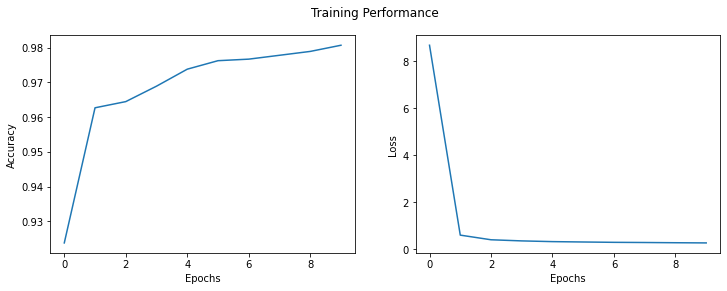

In [12]:
# Plot the training performance
plt.figure(figsize=(12,4))
plt.suptitle('Training Performance')

plt.subplot(121)
plt.plot(X_Train_fit.epoch,X_Train_fit.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.plot(X_Train_fit.epoch,X_Train_fit.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

### Testing the model
For testing the model, we will use a separate set of lattice configurations generated using the same process as the training set.
At first we will repeat the same process as the training set to measure the average critical teperature $T_c$ of the test data. In order to estimate the accuracy of the model on the test data, we will label the 'Phase' of the configuration as 1 or 0 depending on whether the temperature $T < T_c$ or $T > T_c$.

In [13]:
ising_data_test = pd.read_csv('/content/drive/MyDrive/Data Science/Data_Sets/Ising/Ising_data2.csv')

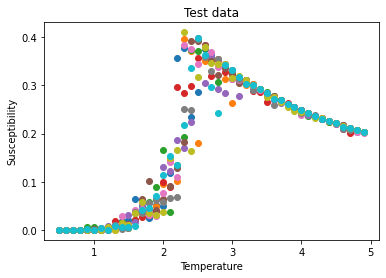


 Critical temperatures:
[2.3 2.3 2.6 2.6 2.5 2.5 2.3 2.5 2.3 2.5]

Critical temperature <Tc> =  2.4400000000000004 

(4500, 400)
(4500,)


In [14]:
X_test = ising_data_test.drop(['Temp','Unnamed: 0'],axis=1)

m = X_test.sum(axis=1)/400; m2 = ((X_test*X_test).sum(axis=1))/400; 
temp = ising_data['Temp']; chi = (m2 - m**2)/temp

mag_test = pd.DataFrame({'m': m,
                     'chi' : chi,
                     'Temp' : temp})

n_init_config = 10; n_meas = 10;
thi = 4.9; tlo = 0.5; tstep = 0.1; ntemp = int((thi-tlo)/tstep)+1;
temperatures = np.linspace(thi,tlo,ntemp);
chi_config_test = np.zeros((ntemp,n_init_config))
m_config_test   = np.zeros((ntemp,n_init_config))
for j in range(n_init_config):
  for i in range(ntemp):
    chi_config_test[i,j] = np.average(mag_test['chi'][j*n_meas*ntemp+i*n_meas:j*n_meas*ntemp+(i+1)*n_meas-1])
    m_config_test[i,j]   = np.average(mag_test['m'][j*n_meas*ntemp+i*n_meas:j*n_meas*ntemp+(i+1)*n_meas-1])

plt.figure()
plt.title('Test data')
plt.ylabel('Susceptibility')
plt.xlabel('Temperature')

for i in range(n_init_config):
  plt.scatter(temperatures,chi_config_test[:,i])

plt.show()

Tcs_test = temperatures[np.argmax(chi_config_test,axis=0)]
Tc_test = np.average(Tcs_test)

print('\n Critical temperatures:')
print(Tcs_test)
print('\nCritical temperature <Tc> = ',Tc_test,'\n')

Y_test = (ising_data_test['Temp']<Tc_test).astype(int)
print(X_test.shape)
print(Y_test.shape)

In [15]:
# Evaluate the model
model.evaluate(
    X_test,
    to_categorical(Y_test)
)

141/141 [==============================] - 0s 1ms/step - loss: 0.2997 - accuracy: 0.9571


[0.29969093203544617, 0.957111120223999]

In [16]:
Y_pred = model.predict(X_test)

In [17]:
Y_pred

array([[0.9835111 , 0.01648896],
       [0.9778227 , 0.0221773 ],
       [0.98141265, 0.01858731],
       ...,
       [0.00495709, 0.9950429 ],
       [0.00495708, 0.9950429 ],
       [0.00495708, 0.9950429 ]], dtype=float32)

In [18]:
Y_pred.shape

(4500, 2)

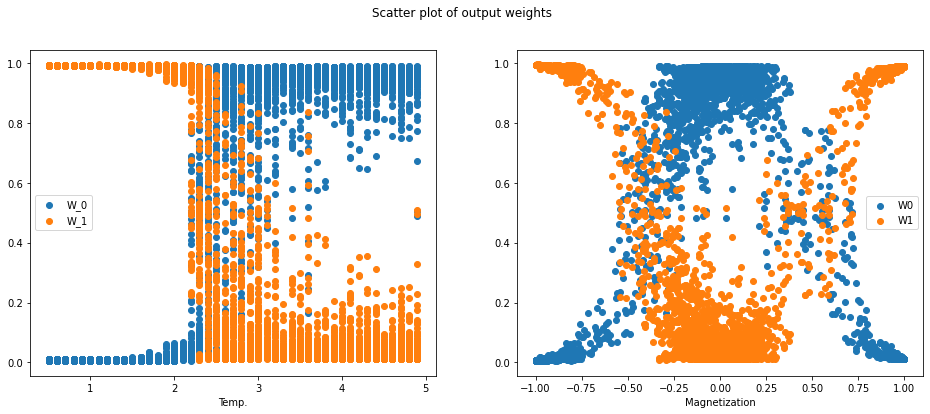

In [19]:
plt.figure(figsize = (16,6))

plt.suptitle('Scatter plot of output weights')

plt.subplot(121)
plt.scatter(temp,Y_pred[:,0],label='W_0')
plt.scatter(temp,Y_pred[:,1],label='W_1')
plt.xlabel('Temp.')
plt.legend()

plt.subplot(122)
plt.scatter(mag_test['m'],Y_pred[:,0],label='W0')
plt.scatter(mag_test['m'],Y_pred[:,1],label='W1')
plt.xlabel('Magnetization')
plt.legend()

From the above plot, it is clear that for configurations corresponding to $T < T_c$, the model identifies them (overwhelmingly) belonging to the ordered phase (i.e. W1 = 1 and W0 = 0); whereas for $T > T_c$, the model identifies them belonging to the dirordered phase (i.e. W1 = 0 and W0 = 1). For $T \approx T_c$, there is an overlapping of the weights, however there is a gradual crossover of the weights.

If we plot the weights versus magnetization, it becomes clearer that weights $W1 \approx 1$ if $m = \pm 1$.

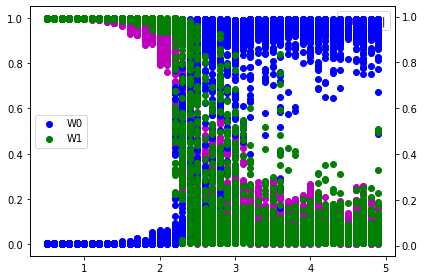

In [20]:
fig, ax1 = plt.subplots()

ax1.scatter(temp,np.abs(mag_test['m']),color='m',label='|m|')
plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(temp,Y_pred[:,0],color='b',label='W0')
ax2.scatter(temp,Y_pred[:,1],color='g',label='W1')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.xlabel('Temp.')
plt.show()

In [21]:
# Sort test data w.r.t. temperature
ising_data_test.sort_values(by='Temp', ascending=False,inplace=True)
Y_test = (ising_data_test['Temp']<Tc_test).astype(int)
X_test = ising_data_test.drop(['Temp','Unnamed: 0'],axis=1)
Y_pred = model.predict(X_test)

In [22]:
Y_pred

array([[0.9835111 , 0.01648896],
       [0.98640025, 0.01359971],
       [0.98568046, 0.01431951],
       ...,
       [0.00495709, 0.9950429 ],
       [0.00495708, 0.9950429 ],
       [0.00495708, 0.9950429 ]], dtype=float32)

In [23]:
nvalues = n_init_config*n_meas

Y_pred_comb = np.zeros((ntemp,2))
for i in range(ntemp):
  Y_pred_comb[i,0] = np.average(Y_pred[i*nvalues:(i+1)*nvalues-1,0])
  Y_pred_comb[i,1] = np.average(Y_pred[i*nvalues:(i+1)*nvalues-1,1])


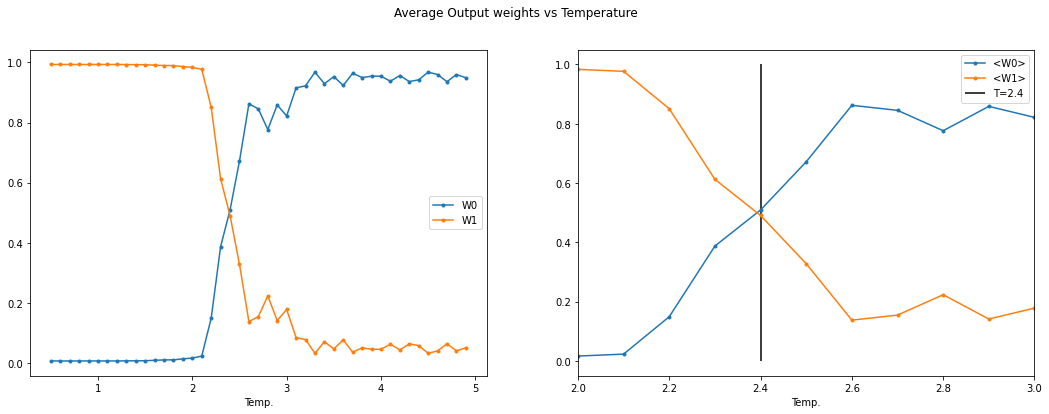

In [27]:
plt.figure(figsize=(18,6))
plt.suptitle('Average Output weights vs Temperature')

plt.subplot(121)
plt.plot(temperatures,Y_pred_comb[:,0],'.-',label='W0')
plt.plot(temperatures,Y_pred_comb[:,1],'.-',label='W1')
plt.xlabel('Temp.')
plt.legend()

plt.subplot(122)
plt.xlim((2.0,3.0))
plt.plot(temperatures,Y_pred_comb[:,0],'.-',label='<W0>')
plt.plot(temperatures,Y_pred_comb[:,1],'.-',label='<W1>')
plt.vlines(x=2.4,ymin=0,ymax=1,label='T=2.4')
plt.xlabel('Temp.')
plt.legend()

As shown in the above graphs, the average weights $<W0>$ and $<W1>$ obtained from the test dataset of the lattice configurations exhibit a crossover at $T\approx 2.4 \approx T_c$.

The above data suffers severly from finite size effcts. Much better results can be obtained by using higher lattice sizes.


The beauty of neural networks and deep learning lies in the fact that the trained model can also be used to locate the phase transitions of other models (e.g. triangular lattice) without any apriori information about the Hamiltonian.